In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner as kt

In [2]:
# Load the data
df = pd.read_csv('datasets/Weekly_U.S.Diesel_Retail_Prices.csv', names=['Date', 'Price'], skiprows=1)

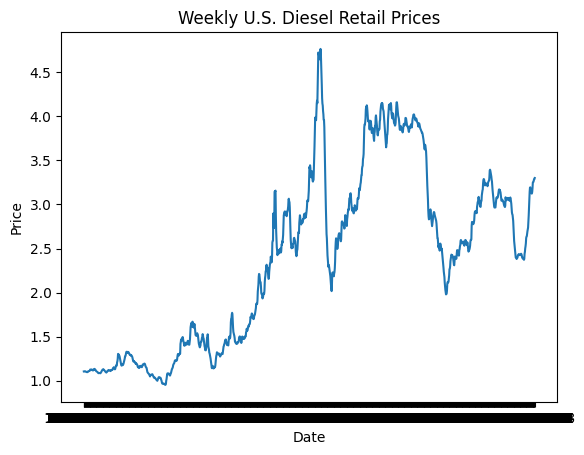

In [3]:
plt.plot(df['Date'], df['Price'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Weekly U.S. Diesel Retail Prices')
plt.show()

In [4]:
df.drop('Date', axis=1, inplace=True)
data = df.values


def normalize(data, min, max):
    data = data - min
    data = data / max
    return data


data_normed = normalize(data, data.min(axis=0), data.max(axis=0))
data_normed[:10]

array([[0.03211587],
       [0.03232578],
       [0.03274559],
       [0.03253568],
       [0.03190596],
       [0.03211587],
       [0.03169605],
       [0.03106633],
       [0.03064652],
       [0.03064652]])

In [5]:
split = int(0.8 * len(data_normed))
train, val = data_normed[:split], data_normed[split:]


def windowed_dataset(series, batch_size, n_past=10, n_future=10, shift=1):
    '''
    :param series: an iterable
    :param batch_size: number of samples per batch
    :param n_past: number of timesteps to look back (x or input to the model)
    :param n_future: number of timesteps to predict (y or output of the model)
    :param shift: number of timesteps to shift the window by, usually 1 if we want to maximise the use of data
    :return:
    '''
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(size=n_past + n_future, shift=shift, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(n_past + n_future))
    ds = ds.map(lambda w: (w[:n_future], w[n_future:]))  # taking the past as x, future as y, split by n_past
    ds.shuffle(8192)
    return ds.batch(batch_size).prefetch(1)


batch_size = 32  # explore how changing this affects the model (it is not as simple as larger batch size = better performance, lik ein image tasks)
n_past = 10
n_future = 10
shift = 1

train_ds = windowed_dataset(train, batch_size, n_past, n_future, shift)
valid_ds = windowed_dataset(val, batch_size, n_past, n_future, shift)

In [11]:
xIn = tf.keras.layers.Input(shape=(n_past, 1)) # 20 input, where first dimension is the number of timesteps to look back, 2nd dimension is the number of features
x = tf.keras.layers.LSTM(32, return_sequences=True)(xIn) # LSTM layer with 32 hidden units. Return
x = tf.keras.layers.LSTM(32)(x)
xOut = tf.keras.layers.Dense(n_future)(x)
model = tf.keras.Model(inputs=xIn, outputs=xOut)
model.compile(loss='mse', optimizer='adam', metrics='mse')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 10, 32)            4352      
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 10)                330       
                                                                 
Total params: 13,002
Trainable params: 13,002
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.fit(train_ds, epochs=100, validation_data=valid_ds)

Epoch 1/100
35/35 [==============================] - 8s 83ms/step - loss: 0.0067 - mse: 0.0067 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 2/100
35/35 [==============================] - 1s 14ms/step - loss: 0.0248 - mse: 0.0248 - val_loss: 0.0269 - val_mse: 0.0269
Epoch 3/100
35/35 [==============================] - 0s 13ms/step - loss: 0.0144 - mse: 0.0144 - val_loss: 0.0095 - val_mse: 0.0095
Epoch 4/100
35/35 [==============================] - 1s 14ms/step - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 5/100
35/35 [==============================] - 0s 14ms/step - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 6/100
35/35 [==============================] - 0s 13ms/step - loss: 0.0038 - mse: 0.0038 - val_loss: 0.0032 - val_mse: 0.0032
Epoch 7/100
35/35 [==============================] - 0s 13ms/step - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 8/100
35/35 [==============================] - 0s 13ms/step - loss: 0.

In [13]:
preds = model.predict(valid_ds)
preds[0]

9/9 [==============================] - 1s 6ms/step


array([0.27196807, 0.27551514, 0.2798989 , 0.27554968, 0.28124323,
       0.27688393, 0.27429107, 0.28214532, 0.2868938 , 0.2872736 ],
      dtype=float32)

In [14]:
def unnormalize(data, min, max):
    data = data * max
    data = data + min
    return data

preds_unnormed = unnormalize(preds, data.min(axis=0), data.max(axis=0))
preds_unnormed[0]

array([2.24865587, 2.26555412, 2.28643842, 2.26571868, 2.29284277,
       2.27207504, 2.25972265, 2.29714031, 2.31976213, 2.32157136])

In [15]:
print(preds_unnormed.shape)
print(preds_unnormed[:, 0])
print(preds_unnormed[:, 0].shape)

(266, 10)
[2.24865587 2.27482871 2.29664722 2.31499663 2.33501699 2.35831307
 2.39165978 2.42514394 2.45828479 2.49673705 2.53555078 2.57257104
 2.60674436 2.63249581 2.64995062 2.65992885 2.66311342 2.66042293
 2.65138602 2.63559718 2.61377086 2.59222964 2.58598458 2.59478582
 2.60869713 2.62121393 2.62884271 2.63129297 2.63202728 2.64233576
 2.66168853 2.68127443 2.69810737 2.70879209 2.70929753 2.70086232
 2.68974684 2.69101953 2.69990453 2.71784633 2.739061   2.76674818
 2.79385837 2.8130862  2.82183774 2.82273561 2.81911743 2.81587238
 2.8147658  2.81607484 2.81871081 2.81869604 2.8125728  2.80351175
 2.79945714 2.8033198  2.81295927 2.82310475 2.82926292 2.82886765
 2.82139391 2.81113485 2.80779722 2.80660887 2.79923735 2.78412661
 2.76379759 2.74625078 2.73475935 2.73010303 2.73258821 2.74256985
 2.76388022 2.78913106 2.81081057 2.82844825 2.87124561 2.92458684
 2.97031463 3.00322548 3.02430329 3.03212629 3.03494314 3.03669941
 3.04214825 3.06130083 3.09002815 3.11598774 3.13805

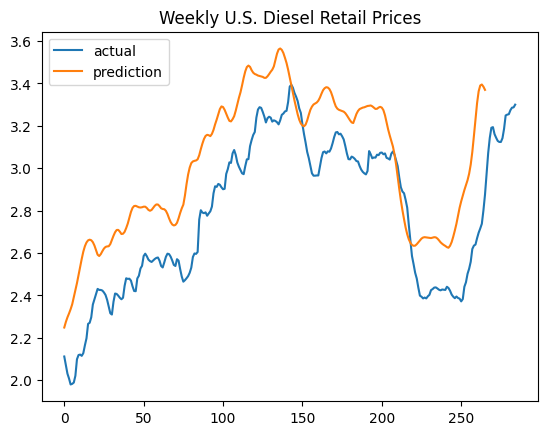

In [16]:
plt.plot(unnormalize(val, data.min(axis=0), data.max(axis=0)), label='actual')  # our val was taken as subset of the normaized data so we need to unnormalize it here
plt.plot(preds_unnormed[:, 0], label='prediction')
plt.legend()
plt.title('Weekly U.S. Diesel Retail Prices')
plt.show()